In [1]:
from transformers import pipeline
import torch
import pandas as pd
import re, unicodedata
import os
import glob
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import json

if torch.cuda.is_available():
    print("GPU disponible !")
    print(f"Nom du GPU : {torch.cuda.get_device_name(0)}")
else:
    print("GPU non disponible, utilisation du CPU.")

c:\Users\Fournier\Documents\Cours CS\fillière recherche\psychological_analysis_of_breast_cancer_patients\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU non disponible, utilisation du CPU.


# Model

In [2]:
classifier = pipeline("text-classification", device="cpu" ,model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)
total_params = sum(p.numel() for p in classifier.model.parameters())
print(f"Nombre total de poids : {total_params}")
classifier("I love this!")

Device set to use cpu
c:\Users\Fournier\Documents\Cours CS\fillière recherche\psychological_analysis_of_breast_cancer_patients\.venv\lib\site-packages\transformers\pipelines\text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Nombre total de poids : 82123783


[[{'label': 'anger', 'score': 0.004419779404997826},
  {'label': 'disgust', 'score': 0.0016119909705594182},
  {'label': 'fear', 'score': 0.00041385178337804973},
  {'label': 'joy', 'score': 0.9771687984466553},
  {'label': 'neutral', 'score': 0.005764589179307222},
  {'label': 'sadness', 'score': 0.002092391485348344},
  {'label': 'surprise', 'score': 0.008528673090040684}]]

In [3]:
def get_table_score_from_output(output_model):
    table_score = {}
    all_dico = output_model[0]
    for dico in all_dico:
        emotion = dico['label']
        table_score[emotion] =dico['score']

    return table_score

# Visualisation

In [4]:
def display_spider_graph_from_score(scores,title=None):
    labels = list(scores.keys())
    values = list(scores.values())

    values += values[:1]
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    ax.plot(angles, values, linewidth=2, linestyle='solid')
    ax.fill(angles, values, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)

    max_value = max(scores.values())

    yticks = np.linspace(0, max_value, 5)[1:] 
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"{y:.2f}" for y in yticks])  
    ax.set_ylim(0, max_value)

    if title is not None:
        ax.set_title(title, size=14, pad=20)

    plt.show()

# Pipeline emotion analyze

In [5]:
def get_emotion_per_features(dict_features_msg,max_features=None):
    dict_EmotionScore = {}
    compteur = 0
    for features, messages in dict_features_msg.items():
        compteur += 1
        score = 0
        if messages:
            print(f"features : {features} ; num of msg : {len(messages)}")
            for sentence in messages:
                try:
                    output_sentence = classifier(sentence)
                except:
                    # if nbr token > max token for the model
                    continue
                score_sentence = get_table_score_from_output(output_sentence)
                if score==0:
                    score = score_sentence
                else:
                    for emotion in score.keys():
                        score[emotion] += score_sentence[emotion]

            # Normalization
            if score != 0:
                for emotion in score.keys():
                    score[emotion] = score[emotion]/len(messages)

                dict_EmotionScore[features] = score

        if compteur == max_features:
            break

    print(f"\nAll features get : {list(dict_EmotionScore.keys())}")
    return dict_EmotionScore

# DATA

In [6]:
def load_all_csv_from_folder(path):
    all_files = glob.glob(os.path.join(path, "*.csv"))
    
    df_list = []
    for file in all_files:
        df = pd.read_csv(file, on_bad_lines='skip')
        df["source_file"] = os.path.basename(file)
        df_list.append(df)
    
    big_df = pd.concat(df_list, ignore_index=True)
    return big_df

df = load_all_csv_from_folder("../data/scraped_data_multithread_in_treatment/")

print(df.columns)



Index(['thread_title', 'nickname', 'comment_time', 'comment_text',
       'source_file', 'thread_title;nickname;comment_time;comment_text'],
      dtype='object')


In [ ]:
dict_thread_conversation = df.groupby('thread_title')['comment_text'].apply(list).to_dict()
print(next(iter(dict_thread_conversation)))
print(next(iter(dict_thread_conversation.values()))[1])

# Username

In [7]:
dict_nickname_comments = df.groupby('nickname')['comment_text'].apply(list).to_dict()
print(next(iter(dict_nickname_comments)))
print(next(iter(dict_nickname_comments.values())))

---faithhopelove---
['I just wanted to say that I was that person always being called back in for more imaging. I am dense and prone to cysts. Since I started DIM all my appointments go very well and I have not been called back once. DIM is also great for breast tenderness. My doctors have noted that my imaging looks much better.', "Glad to read all this. I'm going through it now!"]


In [8]:
dict_username_EmotionScore = get_emotion_per_features(dict_nickname_comments,max_features=20)

features : ---faithhopelove--- ; num of msg : 2
features : 01ElCid ; num of msg : 2
features : 05survivor ; num of msg : 1
features : 08172016 ; num of msg : 1
features : 11heartbeats ; num of msg : 1
features : 11newgirl11 ; num of msg : 1
features : 123_ABC ; num of msg : 2
features : 123justme ; num of msg : 1
features : 1965sally ; num of msg : 9
features : 1982m ; num of msg : 35


Token indices sequence length is longer than the specified maximum sequence length for this model (688 > 512). Running this sequence through the model will result in indexing errors


features : 1Athena1 ; num of msg : 8
features : 1Chopper ; num of msg : 1
features : 1WonderWoman ; num of msg : 11
features : 1maymay1 ; num of msg : 1
features : 1openheart ; num of msg : 2
features : 1redgirl ; num of msg : 10
features : 1verypainful ; num of msg : 1
features : 2002chickadee ; num of msg : 2
features : 2019whatayear ; num of msg : 16
features : 2Ally2 ; num of msg : 1

All features get : ['---faithhopelove---', '01ElCid', '05survivor', '08172016', '11heartbeats', '11newgirl11', '123_ABC', '123justme', '1965sally', '1982m', '1Athena1', '1Chopper', '1WonderWoman', '1maymay1', '1openheart', '1redgirl', '1verypainful', '2002chickadee', '2019whatayear', '2Ally2']


nickname : 1Chopper ; num of msg : 1
{'anger': 0.019886543974280357, 'disgust': 0.04374060779809952, 'fear': 0.07060220837593079, 'joy': 0.005484547466039658, 'neutral': 0.35973548889160156, 'sadness': 0.27261248230934143, 'surprise': 0.22793811559677124}


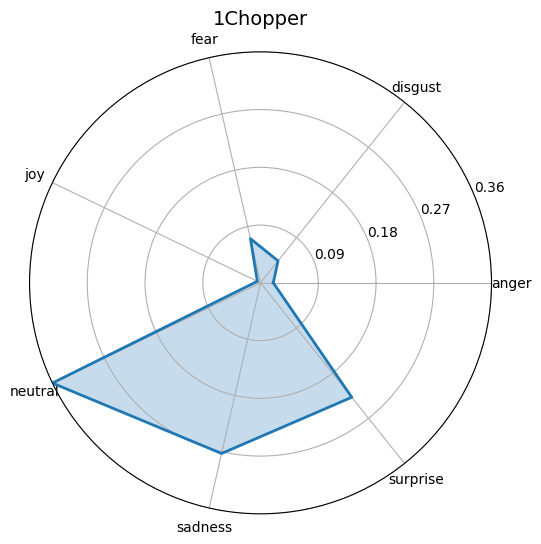

In [12]:
nickname="1Chopper"
print(f"nickname : {nickname} ; num of msg : {len(dict_nickname_comments[nickname])}")
print(dict_username_EmotionScore[nickname])
display_spider_graph_from_score(dict_username_EmotionScore[nickname],title=nickname)